In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [28]:


# read csv

df = pd.read_csv("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")


In [47]:
df.head(1)

,Open,High,Low,Close,Volume,year,Month,Day,Price_Range,Average_Price
0,0.121875,0.125,0.096354,0.097917,1443120000,1997,5,15,0.028646,0.110677


In [29]:
# Features and Target
features = ['Open', 'High', 'Low', 'Volume', 'year', 'Month', 'Day', 'Price_Range', 'Average_Price']
target = 'Close'

In [56]:
X = df[features].values
y = df[[target]].values



In [57]:
# Convert to sequences (for LSTM)
def create_sequences(X, y, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_len = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)


In [58]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [59]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [60]:
# Dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [61]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use the last time step
        return out

In [62]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

In [63]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [64]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.0001
Epoch 2/5, Loss: 0.0000
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0002
Epoch 5/5, Loss: 0.0000


In [66]:
# Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()
    actual = y_test_tensor.numpy()


In [68]:
# Predict

new_input = np.array([[df['Open'].iloc[-1], df['High'].iloc[-1], df['Low'].iloc[-1],
                      df['Volume'].iloc[-1], df['year'].iloc[-1], df['Month'].iloc[-1],
                      df['Day'].iloc[-1], df['Price_Range'].iloc[-1], df['Average_Price'].iloc[-1]]])
scaled_input = scaler_x.transform(new_input.reshape(1, -1))  # reshape for model
scaled_input = torch.tensor(scaled_input, dtype=torch.float32).unsqueeze(0)  # add batch
scaled_prediction = model(scaled_input)
scaled_prediction = scaled_prediction.detach().numpy()
predicted_price = scaler_y.inverse_transform(scaled_prediction) 

In [69]:
# accuracy
from sklearn.metrics import r2_score
accuracy = r2_score(actual_prices, predicted_prices)
print(f"LSTM R2 Score: {accuracy:.4f}")

LSTM R2 Score: 0.9082


In [70]:
import matplotlib.pyplot as plt

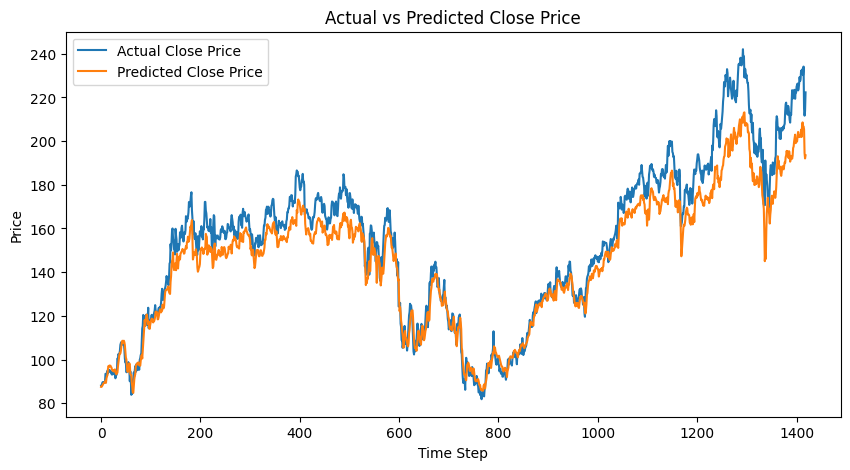

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.legend()
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

In [72]:
# predict close price for next day
last_sequence = X_scaled[-seq_len:].reshape(1, seq_len, -1)
last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32)
with torch.no_grad():
    next_day_pred = model(last_sequence_tensor).numpy()
next_day_price = scaler_y.inverse_transform(next_day_pred)
print(f"Predicted Close Price for Next Day: {next_day_price[0][0]:.2f}")
# Save the model
# torch.save(model.state_dict(), 'lstm_stock_model.pth')


Predicted Close Price for Next Day: 176.45


In [73]:
last_sequence = X_scaled[-seq_len:].reshape(1, seq_len, -1)
last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32)

with torch.no_grad():
    next_day_pred = model(last_sequence_tensor).numpy()

next_day_price = scaler_y.inverse_transform(next_day_pred)
print(f"Predicted Close Price for Next Day: {next_day_price[0][0]:.2f}")


Predicted Close Price for Next Day: 176.45


In [74]:
print("Original y sample:", y[:5])
print("Scaled y sample:", y_scaled[:5])
print("Predicted prices sample:", predicted_prices[:5])


Original y sample: [[0.097917]
 [0.086458]
 [0.085417]
 [0.081771]
 [0.071354]]
Scaled y sample: [[1.16223694e-04]
 [6.88705358e-05]
 [6.45687290e-05]
 [4.95019984e-05]
 [6.45480389e-06]]
Predicted prices sample: [[87.50169 ]
 [87.46101 ]
 [87.804054]
 [88.1469  ]
 [88.66616 ]]


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.style.use("fivethirtyeight")


def train_lstm_model(data):
    # Select 'Close' column and reshape for scaling
    close_data = data[['Close']].values

    # Save original prices before scaling
    original_y_sample = close_data[:5]

    # Scale the data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_data)

    # Save scaled sample
    scaled_y_sample = scaled_data[:5]

    # Prepare training data
    x_train = []
    y_train = []

    for i in range(60, len(scaled_data)):
        x_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape for LSTM input: [samples, timesteps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=1, batch_size=32)

    # Testing on the last 60 days
    test_data = scaled_data[-60:]
    test_data = np.reshape(test_data, (1, test_data.shape[0], 1))
    predicted_scaled_price = model.predict(test_data)

    # Inverse scale prediction
    predicted_price = scaler.inverse_transform(predicted_scaled_price)

    # Output samples
    print("\nOriginal y sample (first 5 rows):")
    print(original_y_sample)

    print("\nScaled y sample (first 5 rows):")
    print(scaled_y_sample)

    print("\nPredicted price (in original scale):")
    print(predicted_price)

    return model, scaler


# Example: Load data and train
if __name__ == "__main__":

    df = pd.read_csv("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")
    model, scaler = train_lstm_model(df)
    # Save the model
    model.save('lstm_stock_model.h5')



/home/yogesh/ml_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-08-07 22:23:16.856473: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_UNSUPPORTED_PTX_VERSION'

2025-08-07 22:23:16.856507: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2025-08-07 22:23:16.856517: W tensorflow/core/framework/op_kernel.cc:1844] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'


InternalError: {{function_node __wrapped__FloorMod_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:FloorMod] name: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")

# Load and preprocess your data
def load_data(filename='stock_data.csv'):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    data = df[['Close']].values  # Use 'Close' prices for prediction
    return data

# Prepare data
def prepare_data(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load data
data = load_data("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training dataset
look_back = 60
X, y = prepare_data(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Convert to PyTorch tensors
X_train = torch.from_numpy(X).float().to(device)
y_train = torch.from_numpy(y).float().to(device).unsqueeze(1)

# Model, loss, optimizer
model = StockLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# Prediction
model.eval()
predicted = model(X_train).detach().cpu().numpy()
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_train.cpu().numpy())

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Stock Price Prediction using LSTM (PyTorch)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


KeyError: 'Date'

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Optional: reduces TensorFlow logs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Force CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


def train_lstm_model(data, time_step=60, epochs=10, batch_size=32):
    """
    Trains an LSTM model to predict the 'Close' price from stock data.

    Parameters:
    - data: DataFrame with stock data including 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
    - time_step: Number of timesteps for input sequences
    - epochs: Number of training epochs
    - batch_size: Training batch size
    """
    # --- Preprocessing ---
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])

    # Create sequences
    def create_dataset(dataset, time_step):
        X, y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[i:(i + time_step)])
            y.append(dataset[i + time_step, 3])  # Close is at index 3
        return np.array(X), np.array(y)

    X, y = create_dataset(scaled_data, time_step)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # --- Model ---
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_step, len(features))),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- Training ---
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # --- Prediction ---
    y_pred = model.predict(X_test)
    y_pred_inverse = scaler.inverse_transform(np.hstack([np.zeros((y_pred.shape[0], 3)), y_pred, np.zeros((y_pred.shape[0], 1))]))[:, 3]
    y_test_inverse = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))]))[:, 3]

    # --- Evaluation ---
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    print(f"Mean Squared Error: {mse:.4f}")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inverse, label="Actual")
    plt.plot(y_pred_inverse, label="Predicted")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.title("Actual vs Predicted Close Prices")
    plt.legend()
    plt.savefig('images/lstm_prediction_plot.png')
    plt.show()

    # --- Save Model ---
    model_path = "models/lstm_model.keras"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    # --- Future Forecasting ---
    future_dates = pd.date_range(start=data.index.max(), periods=30, freq='B')
    future_data = pd.DataFrame(index=future_dates, columns=features)
    last_row = data[features].iloc[-1]
    for col in features:
        future_data[col] = last_row[col]

    future_scaled = scaler.transform(future_data)
    X_future = []
    for i in range(len(future_scaled) - time_step):
        X_future.append(future_scaled[i:i+time_step])
    X_future = np.array(X_future)

    if X_future.shape[0] > 0:
        future_pred = model.predict(X_future)
        future_pred_inverse = scaler.inverse_transform(np.hstack([np.zeros((future_pred.shape[0], 3)), future_pred, np.zeros((future_pred.shape[0], 1))]))[:, 3]
    else:
        future_pred_inverse = []

    future_data['Predicted Close'] = pd.Series(future_pred_inverse, index=future_data.index[time_step:time_step + len(future_pred_inverse)])
    future_data.to_csv('data/future_predictions_lstm.csv')
    print("Future predictions saved to: data/future_predictions_lstm.csv")


# Example usage
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('/home/yogesh/genai/stock price prediction/notebook/cleaned_stock_data.csv')  # Replace with your file
    train_lstm_model(df)


/home/yogesh/ml_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-08-07 22:37:50.167724: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_UNSUPPORTED_PTX_VERSION'

2025-08-07 22:37:50.167749: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2025-08-07 22:37:50.167757: W tensorflow/core/framework/op_kernel.cc:1844] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2025-08-07 22:37:50.167773: I tensorflow/core/framework/local_rende

InternalError: {{function_node __wrapped__FloorMod_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:FloorMod] name: 

Epoch 1/30, Loss: 0.000229
Epoch 2/30, Loss: 0.000018
Epoch 3/30, Loss: 0.000082
Epoch 4/30, Loss: 0.000036
Epoch 5/30, Loss: 0.000072
Epoch 6/30, Loss: 0.000040
Epoch 7/30, Loss: 0.000017
Epoch 8/30, Loss: 0.000052
Epoch 9/30, Loss: 0.000033
Epoch 10/30, Loss: 0.000002
Epoch 11/30, Loss: 0.000018
Epoch 12/30, Loss: 0.000004
Epoch 13/30, Loss: 0.000021
Epoch 14/30, Loss: 0.000009
Epoch 15/30, Loss: 0.000057
Epoch 16/30, Loss: 0.000005
Epoch 17/30, Loss: 0.000004
Epoch 18/30, Loss: 0.000006
Epoch 19/30, Loss: 0.000007
Epoch 20/30, Loss: 0.000011
Epoch 21/30, Loss: 0.000043
Epoch 22/30, Loss: 0.000011
Epoch 23/30, Loss: 0.000029
Epoch 24/30, Loss: 0.000010
Epoch 25/30, Loss: 0.000012
Epoch 26/30, Loss: 0.000016
Epoch 27/30, Loss: 0.000022
Epoch 28/30, Loss: 0.000020
Epoch 29/30, Loss: 0.000020
Epoch 30/30, Loss: 0.000008


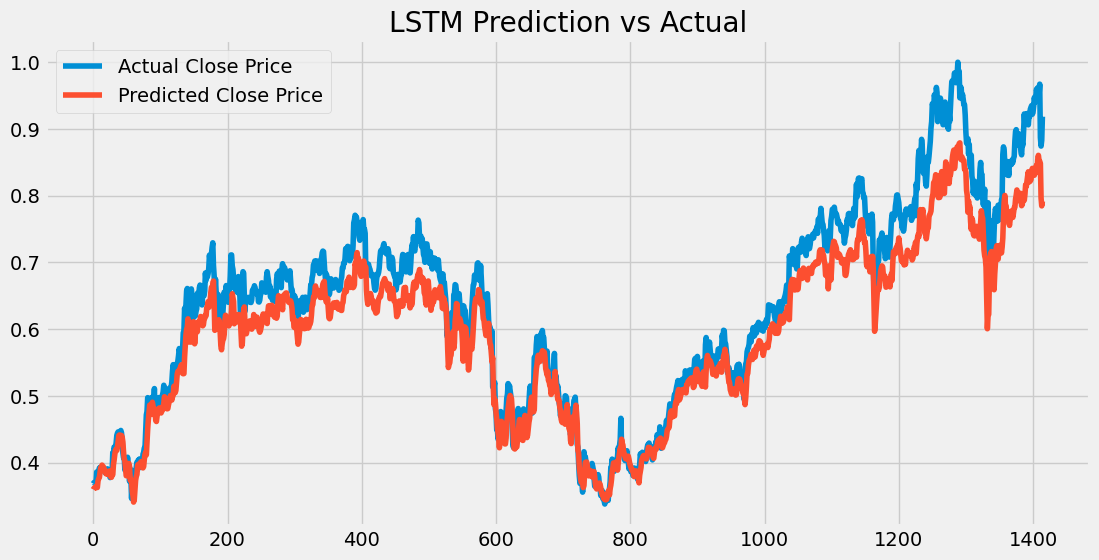

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# =======================
# Load and preprocess data
# =======================
df = pd.read_csv("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")  # Replace with your file path

# Sort by date if not already sorted
df = df.sort_values(by=["year", "Month", "Day"])

# Use all numeric columns as features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Range', 'Average_Price', 'year', 'Month', 'Day']
target = 'Close'

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

X_all = []
y_all = []

seq_len = 30  # Use last 30 days to predict next day

for i in range(seq_len, len(df)):
    X_all.append(scaled_data[i-seq_len:i])
    y_all.append(scaled_data[i][features.index('Close')])  # Index of Close after scaling

X_all = np.array(X_all)
y_all = np.array(y_all)

# Convert to torch tensors
X_all = torch.tensor(X_all, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.float32).unsqueeze(1)

# Train/Test Split
train_size = int(0.8 * len(X_all))
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# =======================
# Custom Dataset
# =======================
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# =======================
# PyTorch LSTM Model
# =======================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

input_size = len(features)
hidden_size = 64
model = LSTMModel(input_size, hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# =======================
# Training
# =======================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# =======================
# Evaluation
# =======================
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch).cpu()
        predictions.extend(output.numpy())
        actuals.extend(y_batch.numpy())

# =======================
# Plotting
# =======================
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()


In [ ]:
# predict next day price




In [90]:

# Load your stock data (make sure it has 'Close' column)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and scale data
df = pd.read_csv("/home/yogesh/genai/stock price prediction/notebook/preprocessed_stock_data.csv")  # Replace with your file path
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Sequence creation
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Dataset and DataLoader
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.6f}")


Epoch [1/20], Loss: 0.015975
Epoch [2/20], Loss: 0.000257
Epoch [3/20], Loss: 0.000215
Epoch [4/20], Loss: 0.000196
Epoch [5/20], Loss: 0.000197
Epoch [6/20], Loss: 0.000177
Epoch [7/20], Loss: 0.000174
Epoch [8/20], Loss: 0.000179
Epoch [9/20], Loss: 0.000168
Epoch [10/20], Loss: 0.000316
Epoch [11/20], Loss: 0.000138
Epoch [12/20], Loss: 0.000141
Epoch [13/20], Loss: 0.000132
Epoch [14/20], Loss: 0.000128
Epoch [15/20], Loss: 0.000126
Epoch [16/20], Loss: 0.000125
Epoch [17/20], Loss: 0.000113
Epoch [18/20], Loss: 0.000097
Epoch [19/20], Loss: 0.000100
Epoch [20/20], Loss: 0.000106


In [91]:
# Predict next day
model.eval()
with torch.no_grad():
    last_seq = torch.tensor(scaled_data[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)
    next_day_scaled = model(last_seq).cpu().numpy()
    next_day_price = scaler.inverse_transform(next_day_scaled)

print(f"\n📈 Predicted Close Price for Next Day: {next_day_price[0][0]:.2f}")



📈 Predicted Close Price for Next Day: 210.22


In [93]:
print(df[-1:])


            Open        High         Low       Close    Volume  year  Month  \
7100  214.699997  222.649994  213.740005  222.309998  54714900  2025      8   

      Day  Price_Range  Average_Price  
7100    6     8.909988        218.195  


In [94]:
# Save the trained LSTM model
model.save("stock_dl_model.h5")
print("✅ Model saved as 'stock_dl_model.h5'")


AttributeError: 'LSTMModel' object has no attribute 'save'